In [1]:
import anndata as ad
import scanpy as sc
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import issparse
import scvelo as scv
import loompy
import re
import bbknn

from IPython.display import Markdown, display
from IPython.core.display import display, HTML
import anndata2ri
from os import environ

sns.set_context('poster')
plt.style.use('seaborn-darkgrid')

display(HTML("<style>.container { width:90% !important; }</style>"))
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80) #resolution

In [2]:
# Activate the anndata2ri conversion between SingleCellExperiment and AnnData
anndata2ri.activate()

#Loading the rpy2 extension enables cell magic to be used
#This runs R code in jupyter notebook cells
%load_ext rpy2.ipython

sc.settings.verbosity = 3
#sc.logging.print_versions()

## Functions

In [32]:
def plotClusterOverlap(adata, marker_file, cluster_key='leiden', gene_rank_key='rank_genes_leiden', remove_somatic=True, normalize='None', rename=True, method='overlap_count'):

    import scanpy as sc
    import string
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns

    with open(marker_file,'r') as f: #read names both lower and upper case
        names=[x.strip().split('\t')[0] for x in f]
    with open(marker_file,'r') as f:
        types=[x.strip().split('\t')[1] for x in f]
    with open(marker_file,'r') as f:
        names2=[x.strip().split('\t')[0].upper() for x in f]

    del names[0] #remove headers
    del names2[0]
    del types[0]

    typesNew = np.concatenate( (np.array(types), np.array(types)) ) #put vectors together and find which genes are in our data
    namesNew = np.concatenate( (np.array(names),np.array(names2)) )
    idx = np.in1d(namesNew, adata.var_names)
    typesNew = typesNew[idx]
    namesNew = namesNew[idx]

    forTypes = np.unique(typesNew)
    clusterDict = dict()
    for tt in forTypes:
        idx = np.in1d( typesNew, tt )
        clusterDict[str(tt)] = np.array(namesNew)[idx]

    if(remove_somatic): #remove somatic cells if you want to
        del clusterDict['Somatic']

    cell_annotation = sc.tl.marker_gene_overlap(adata, clusterDict, key=gene_rank_key, normalize=normalize, method=method)

    nameCluster = []
    for i in range(cell_annotation.max().size): #find cluster names from overlapping matrix
        nameCluster.append( np.array( cell_annotation.index[ cell_annotation[str(i)] == cell_annotation.max()[i]  ] ) )

    for i in range(cell_annotation.max().size): #resolve duplicated names
        nameCluster[i] = '+'.join(nameCluster[i])

    nameCluster=np.array(nameCluster)
    newCluster=nameCluster
    for i in np.unique(nameCluster):
        idx = [j==i for j in nameCluster]
        if sum(idx)>1:
            numbers=range(1, (sum(idx))+1 )
            newCluster[idx]= ["{}-{}".format(a,b) for a,b in zip( nameCluster[idx], numbers )]

    plt.rcParams['figure.figsize']=(15,15)
    sns.heatmap(cell_annotation, cbar=False, annot=True )
    plt.rcParams['figure.figsize']=(6,6)
    
    return cell_annotation


In [51]:
def rescale(array,new_min_value,new_max_value):
    min_value = min(array)
    max_value = max(array)
    scaled_array = ( array - min_value ) / ( max_value - min_value )
    new_values = (new_max_value-new_min_value)*scaled_array + new_min_value
    return new_values

## Input and output files

In [4]:
adata_in = "/home/mtxellrb/primatescrna/UPDATED/HEID_DATA_single_annot/HUM/adata/preproc_1_starsolo_multimap.h5ad"
adata_out_norm =  "/home/mtxellrb/primatescrna/UPDATED/HEID_DATA_single_annot/HUM/adata/preproc_2_starsolo_multimap_sctransf.h5ad"
adata_out_clst =  "/home/mtxellrb/primatescrna/UPDATED/HEID_DATA_single_annot/HUM/adata/preproc_3_starsolo_multimap.h5ad"

## Sc-transform

In [5]:
adata = sc.read(adata_in)

In [8]:
repl_sampl_dict ={
    "SN007":"HUM_1",
    "SN011":"HUM_1",
    "SN052":"HUM_1",
    "SN111":"HUM_2",
    "SN142_highseq":"HUM_2",
    "SN142_lowseq":"HUM_2"
}

adata.obs["DATASET_repl"] = adata.obs["DATASET"].copy()
adata.obs["DATASET"] = [repl_sampl_dict[x] for x in adata.obs["DATASET_repl"]]

In [ ]:
adata.obs["DATASET_repl"]

In [10]:
rawMatrix = adata.X.todense().T
cells = adata.obs_names
genes = adata.var_names
dataset = np.array(adata.obs["DATASET"])

In [11]:
rawMatrix.shape

(27233, 11785)

In [12]:
%%R -i rawMatrix -i cells -i genes -i dataset -o norm_sct -o umi_corr -o genes_var # input and output

library(Seurat)
colnames(rawMatrix) <- cells
rownames(rawMatrix) <- genes
meta <- data.frame(DATASET = dataset) # add batch as metadata
print(dim(rawMatrix))
seurat_df <- CreateSeuratObject(rawMatrix)
seurat_df <- AddMetaData(seurat_df, meta$DATASET, col.name = "DATASET")
# scTransform
seurat_df <- SCTransform(seurat_df, verbose = TRUE, variable.features.n = length(genes), vars.to.regress = c("DATASET"), return.only.var.genes=FALSE) # run normalization (Negative binomial regression), removal of the technical variation from batch effect
# Get matrix of residuals
norm_sct <- GetAssayData(seurat_df,assay="SCT",slot="scale.data") 
umi_corr <- GetAssayData(seurat_df,assay="SCT",slot="counts")
genes_var <- rownames(seurat_df$SCT)

R[write to console]: Attaching SeuratObject



[1] 27233 11785


R[write to console]: Warning:
R[write to console]:  Feature names cannot have underscores ('_'), replacing with dashes ('-')

R[write to console]: Calculating cell attributes from input UMI matrix: log_umi

R[write to console]: Variance stabilizing transformation of count matrix of size 27233 by 11785

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 2000 genes, 5000 cells



  |======================================================================| 100%


R[write to console]: Found 28 outliers - those will be ignored in fitting/regularization step


R[write to console]: Second step: Get residuals using fitted parameters for 27233 genes



  |======================================================================| 100%


R[write to console]: Computing corrected count matrix for 27233 genes



  |======================================================================| 100%


R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 2.194796 mins

R[write to console]: Determine variable features

R[write to console]: Place corrected count matrix in counts slot

R[write to console]: Regressing out DATASET

  |                                                                            
  |                                                                      |   0%
  |                                                                            
  |                                                                      |   1%
  |                                                                            
  |=                                                                     |   1%
  |                                                                            
  |=                                                                     |   2%
  |                                                                        

In [13]:
norm_sct.shape

(27233, 11785)

In [14]:
# remove objects from R workspace that I will no longer need
%%R 
rm(list = ls())

In [15]:
adata.var_names = ["-".join(x.split("_")) for x in adata.var_names] # change - in names to _
adata = adata[:,np.array(genes_var)].copy()
adata.layers["norm_sct"] = norm_sct.T
adata.layers["umi_corr"] = umi_corr.T

## Dimension reduction

In [67]:
adata.X = adata.layers['norm_sct'].copy()

In [68]:
sc.pp.pca(adata)

computing PCA
    with n_comps=50
    finished (0:00:26)


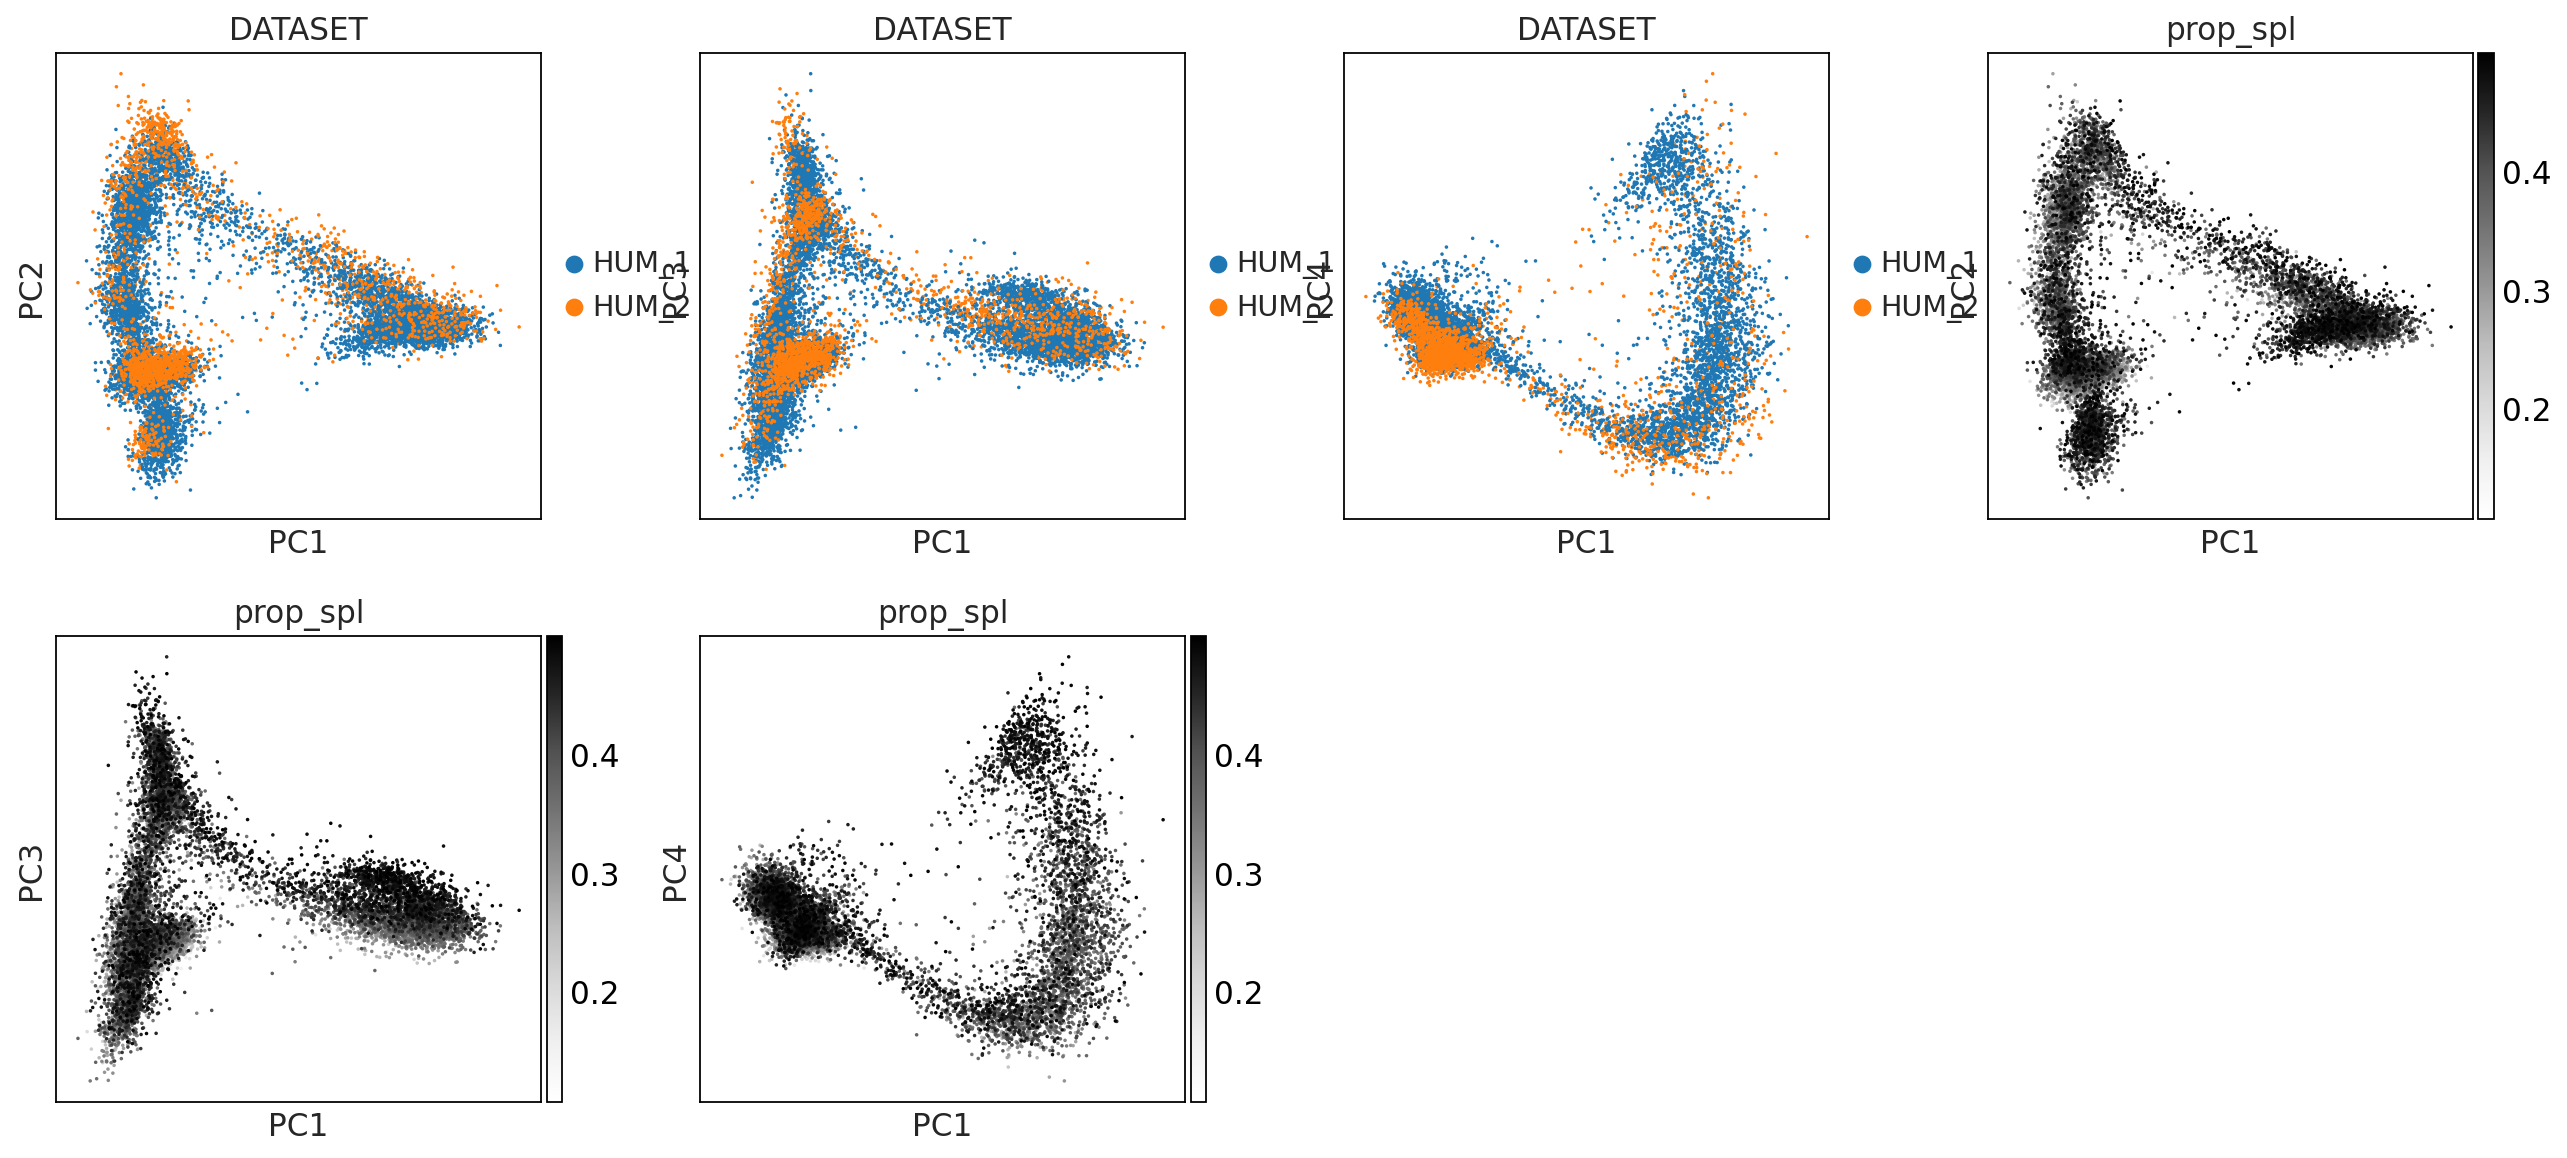

In [69]:
sc.pl.pca(adata, color=['DATASET','prop_spl'], components=['1,2','1,3','1,4'])

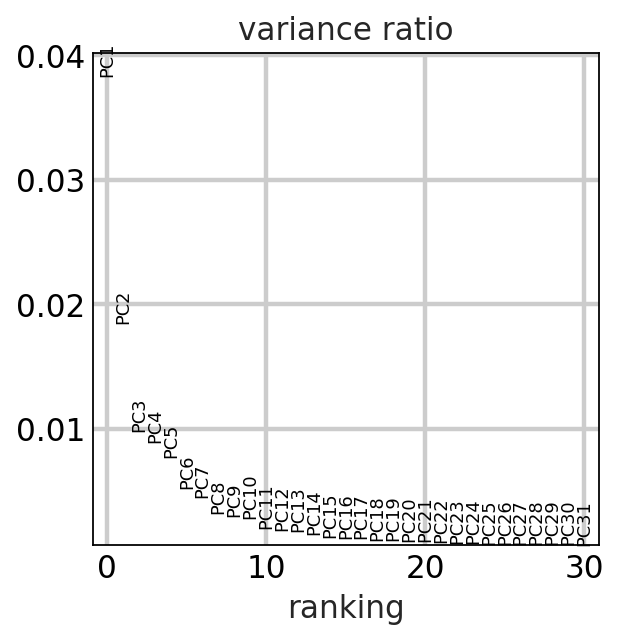

In [70]:
sc.pl.pca_variance_ratio(adata)

In [71]:
bbknn.bbknn(adata,batch_key='DATASET',n_pcs=10,neighbors_within_batch=5,trim=10000,approx=False,use_faiss=False)

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	`.obsp['distances']`, distances for each pair of neighbors
	`.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [72]:
sc.tl.umap(adata, spread=1, min_dist=.3)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)


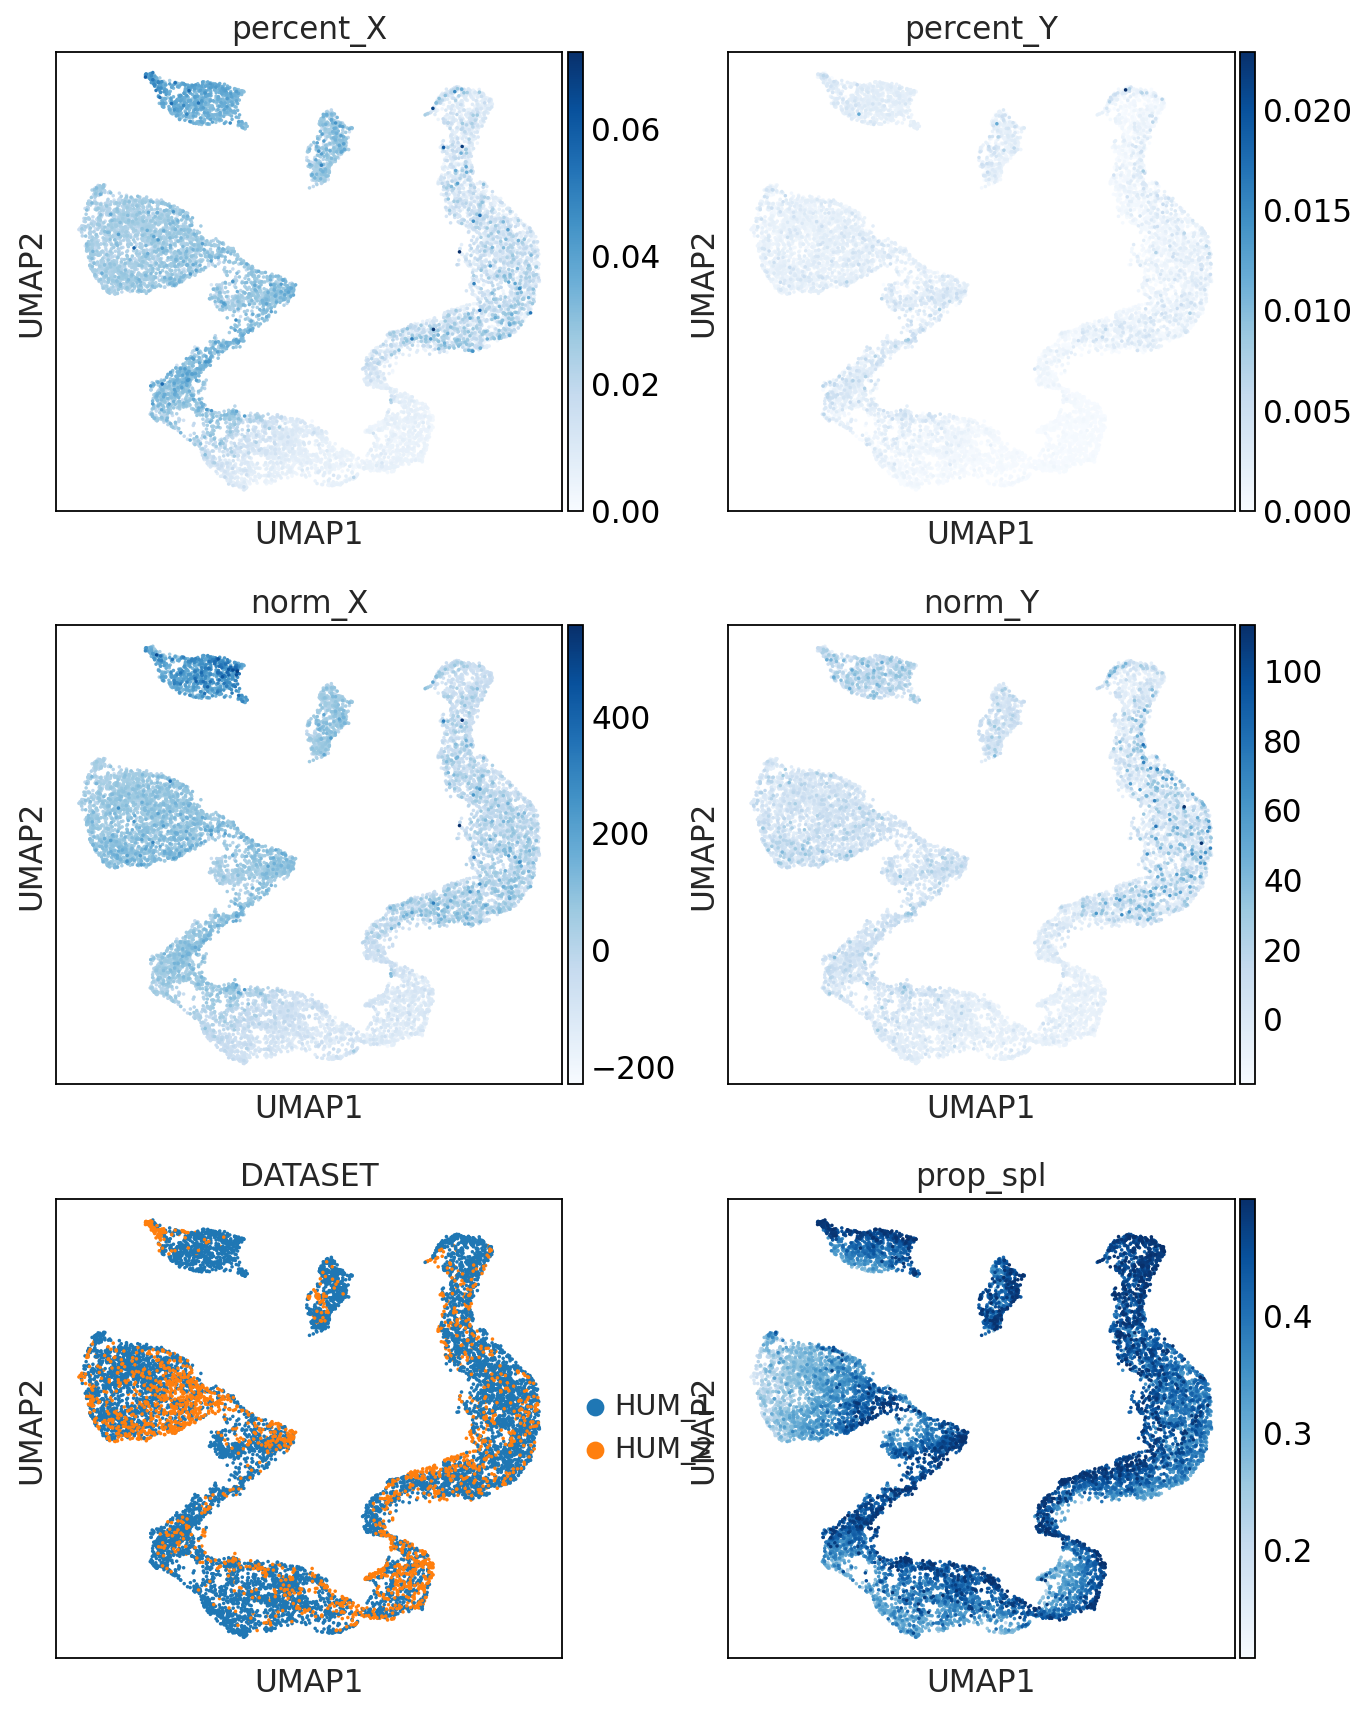

In [76]:
sc.pl.umap(adata, color=['DATASET', 'prop_spl'], cmap='Blues', ncols=2)

In [66]:
adata.write(adata_out_norm)

## Clustering

In [36]:
sc.tl.leiden(adata, resolution=.3, random_state=21090)

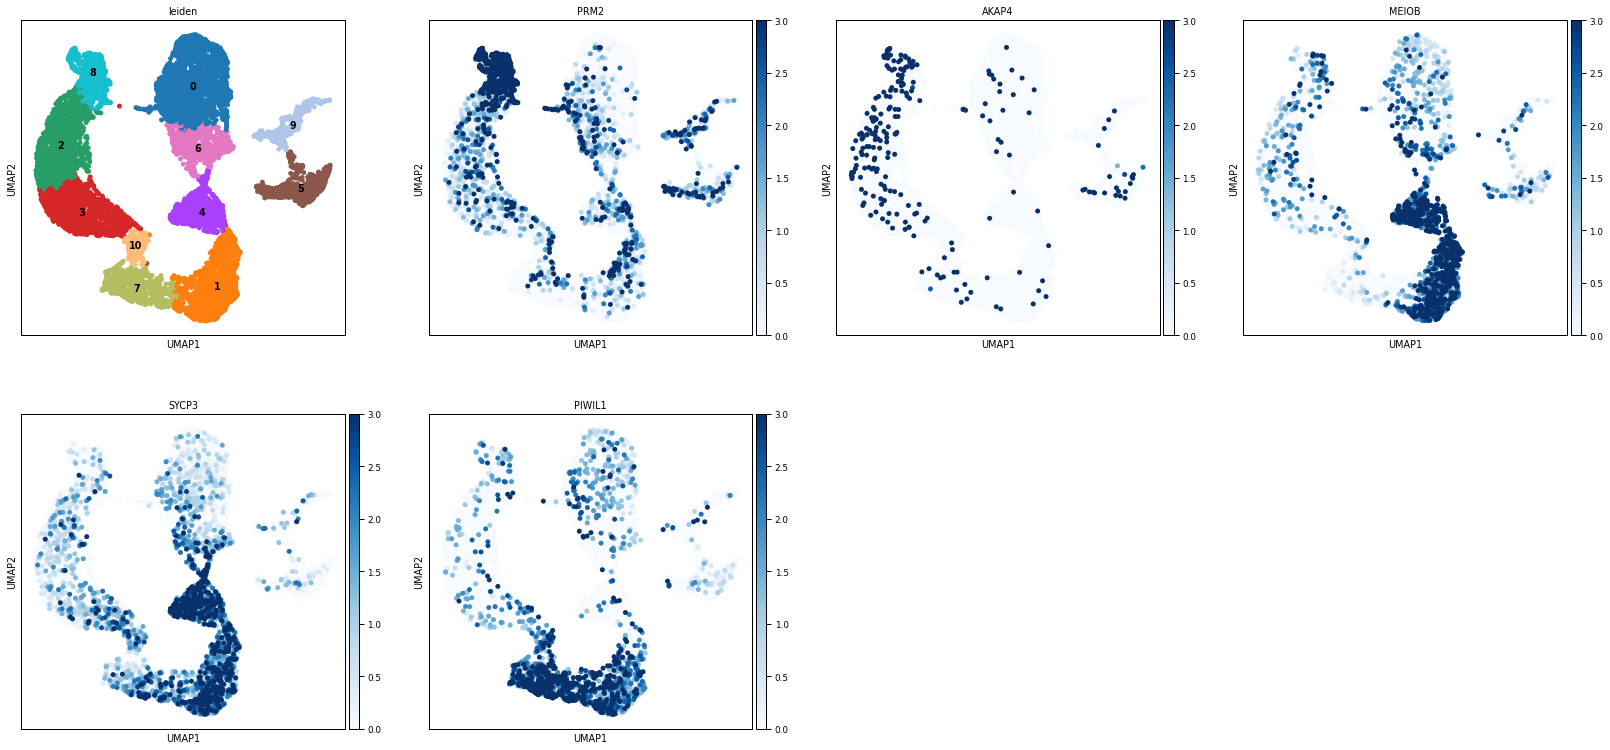

In [37]:
sc.pl.umap(adata, color=['leiden','PRM2','AKAP4','MEIOB','SYCP3','PIWIL1'], size=100, legend_loc='on data', cmap='Blues',
          vmin=0, vmax=3)

In [38]:
sc.tl.rank_genes_groups(adata, groupby='leiden', key_added='DE_leiden')

/home/mtxellrb/miniconda3/envs/preproc_XandY/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


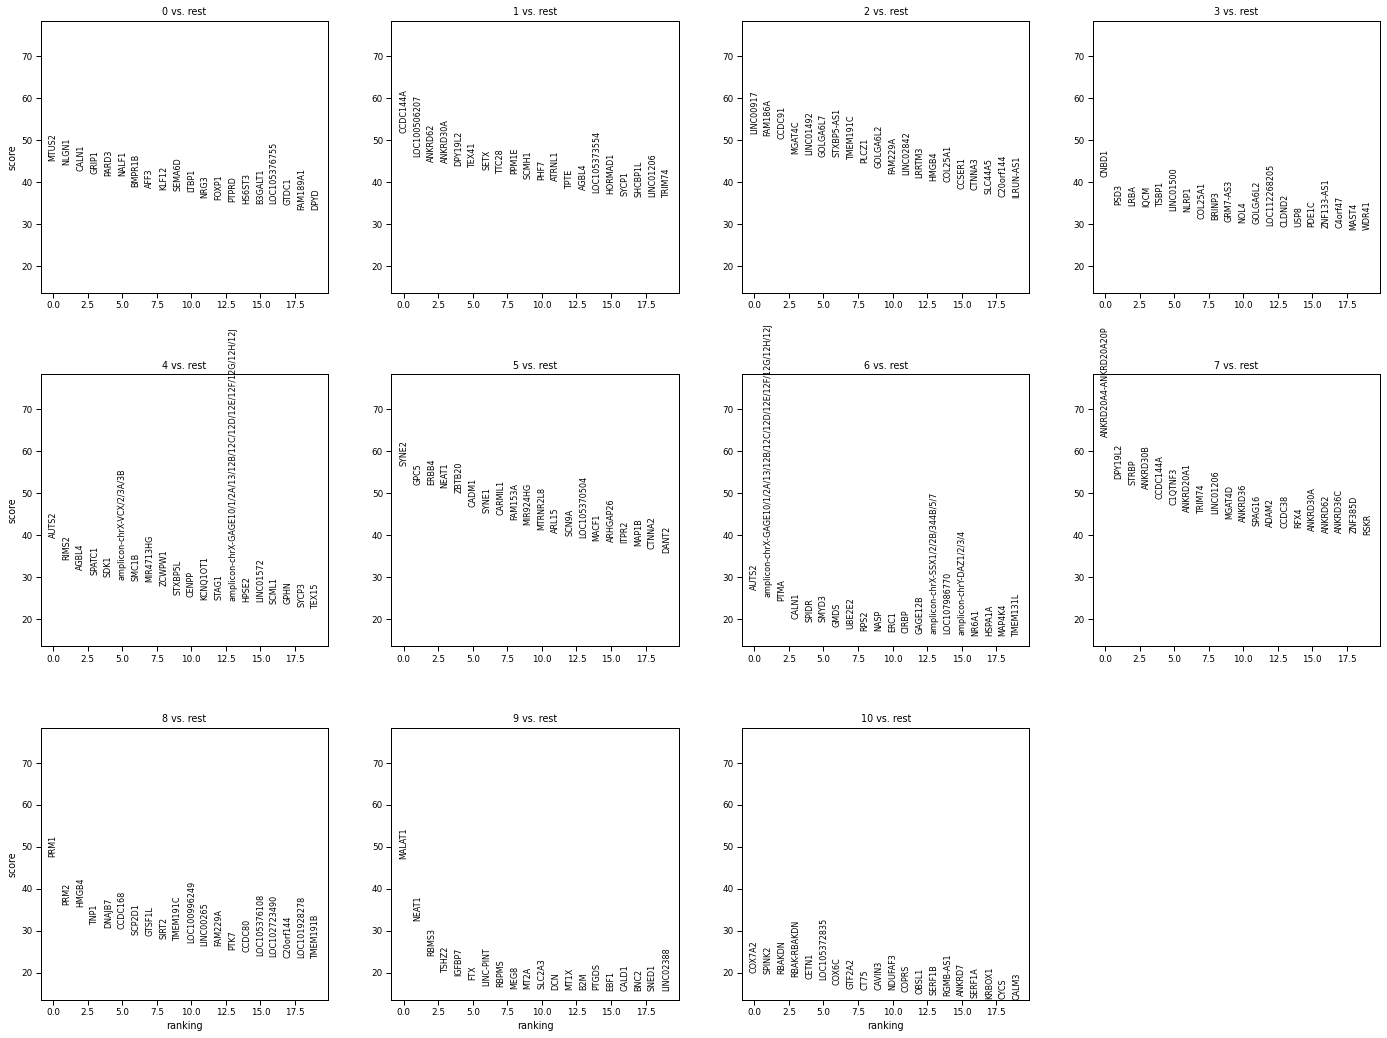

In [39]:
sc.pl.rank_genes_groups(adata, groupby='leiden', key='DE_leiden')

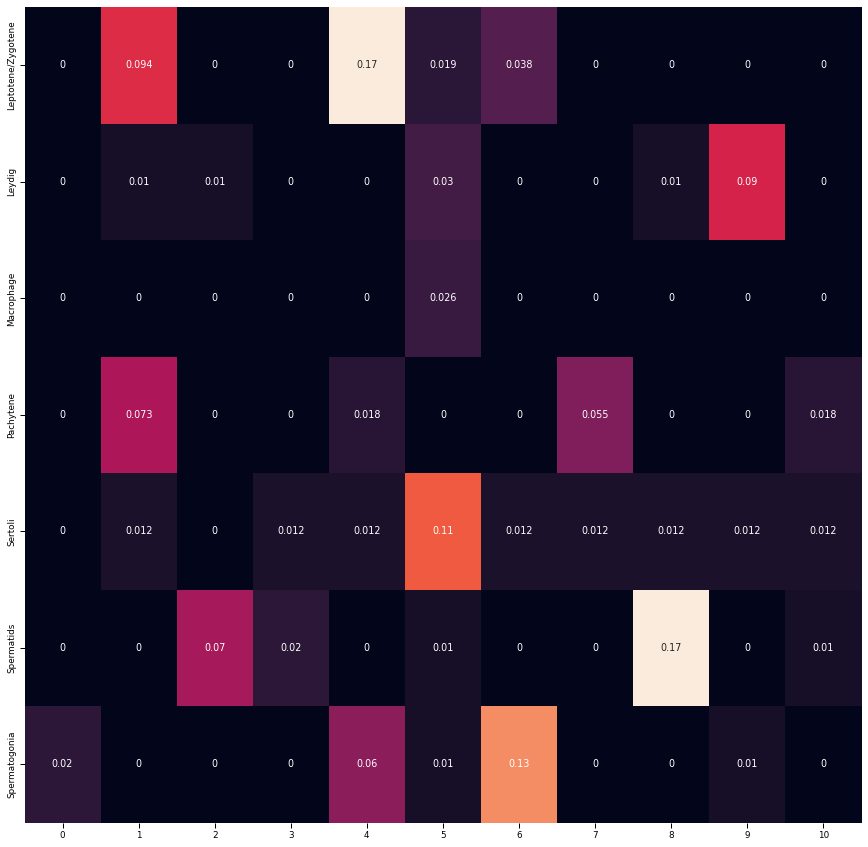

In [40]:
cell_annotation = plotClusterOverlap(adata=adata, marker_file="/home/mtxellrb/primatescrna/UPDATED/interesting_genes/markers_jung_subset.tsv", 
              cluster_key='leiden', gene_rank_key='DE_leiden', remove_somatic=False, rename=False, 
              normalize='None', method='overlap_coef')

In [41]:
'''
cell_type_dict = {}

for clst in cell_annotation.columns:
    cell_type = [cell_annotation.index[idx] for idx,x in enumerate(cell_annotation[clst]) if x == max(cell_annotation[clst])]
    cell_type_dict[clst] = cell_type[0]
    
adata.obs['cluster'] = [cell_type_dict[x] for x in adata.obs['leiden'].tolist()]
'''

In [22]:
clst_dict ={
    "0":'SPT2',
    "1":'SPT3',
    "2":'SPG1',
    "3":'SPC2',
    "4":'SPT1',
    "5":'SPC3',
    "6":'SPG2',
    "7":'SPC1',
    "8":'Somatic',
    "9":'Somatic'
}

adata.obs['cluster'] = [clst_dict[x] for x in adata.obs['leiden'].tolist()]

... storing 'cluster' as categorical


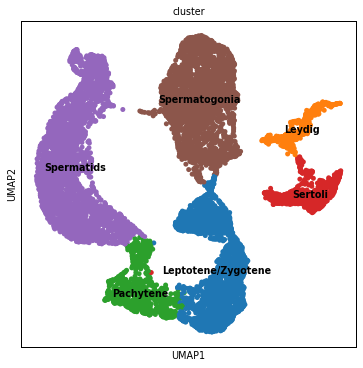

In [43]:
sc.pl.umap(adata, color='cluster', size=100, legend_loc='on data', cmap='Blues',
          vmin=1, vmax=3)

In [44]:
recluster = np.asarray( adata.obs['cluster'] )
recluster[ np.in1d(recluster,['Spermatids']) ] = 'SPT'
recluster[ np.in1d(recluster,['Pachytene','Leptotene/Zygotene']) ] = 'SPC'
recluster[ np.in1d(recluster,['Spermatogonia']) ] = 'SPG'
adata.obs['clst_groups'] = pd.Categorical(recluster)
#adata.obs['clst_groups'] = adata.obs['cluster'].copy()

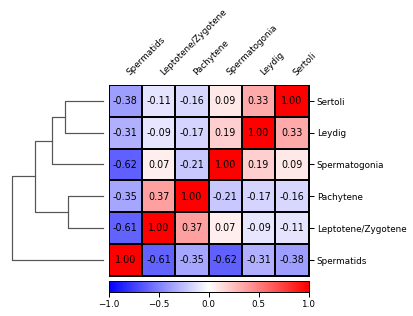

In [45]:
sns.set_context("paper")
sc.pl.correlation_matrix(adata, 'cluster', show_correlation_numbers=True)

## Pseudotime

In [ ]:
adata_somatic = adata[adata.obs['clst_groups'].isin(["Sertoli","Leydig"]),:].copy()

In [46]:
adata = adata[adata.obs['clst_groups'].isin(["SPG","SPC","SPT"]),:].copy()

In [48]:
aut_genes = [ gene for index,gene in enumerate(adata.var_names) if not (adata.var['chromosome'][index].startswith("X") or adata.var['chromosome'][index].startswith("Y") ) ]

In [ ]:
adata_subs = adata[:,aut_genes].copy()
sc.pp.highly_variable_genes(adata_subs)
adata_subs = adata_subs[:,adata_subs.var["highly_variable"]==True].copy()
adata_subs.uns['iroot'] = np.flatnonzero(adata_subs.obs['cluster'] == 'Spermatogonia')[0]
sc.tl.diffmap(adata_subs)
sc.tl.dpt(adata_subs,n_dcs=2)
adata.obs["dpt_pseudotime"] = adata_subs.obs["dpt_pseudotime"].copy()
sc.pl.umap(adata, color=['clst_groups','dpt_pseudotime','prop_spl','DATASET'], legend_loc='on data', legend_fontsize=16, size=50)

/home/mtxellrb/miniconda3/envs/preproc_XandY/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:208: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


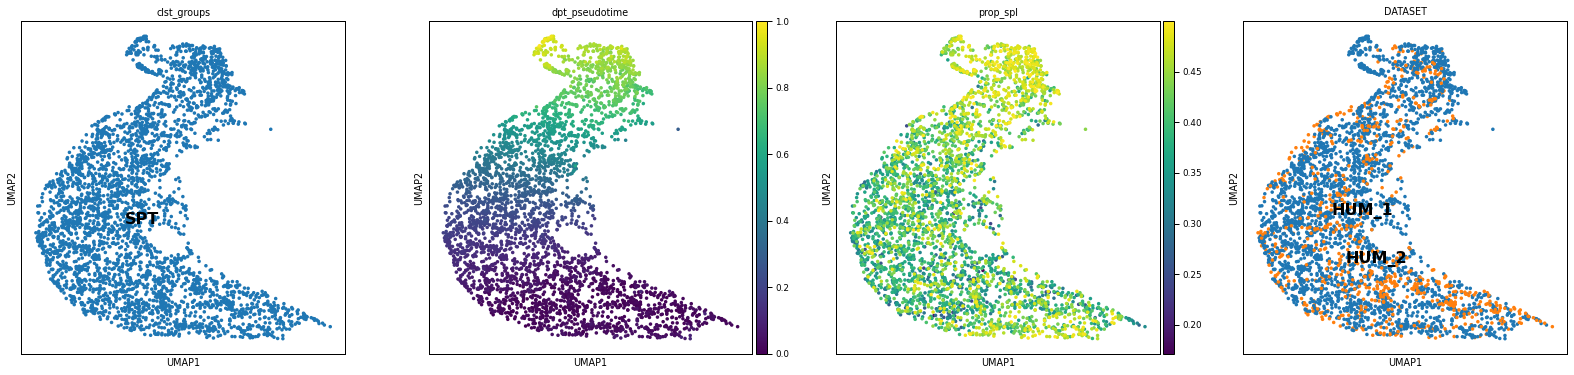

In [49]:
'''
d_spt = adata[adata.obs["clst_groups"]=="SPT"].copy()
d_spt_subs = d_spt[:,aut_genes].copy()
sc.pp.highly_variable_genes(d_spt_subs)
d_spt_subs = d_spt_subs[:,d_spt_subs.var["highly_variable"]==True].copy()
d_spt_subs.uns['iroot'] = np.flatnonzero(d_spt_subs.obs['cluster'] == 'Spermatids')[0]
sc.tl.diffmap(d_spt_subs)
sc.tl.dpt(d_spt_subs,n_dcs=2)
d_spt.obs["dpt_pseudotime"] = d_spt_subs.obs["dpt_pseudotime"].copy()
sc.pl.umap(d_spt, color=['clst_groups','dpt_pseudotime','prop_spl','DATASET'], legend_loc='on data', legend_fontsize=16, size=50)
'''

/home/mtxellrb/miniconda3/envs/preproc_XandY/lib/python3.9/site-packages/scanpy/preprocessing/_highly_variable_genes.py:208: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


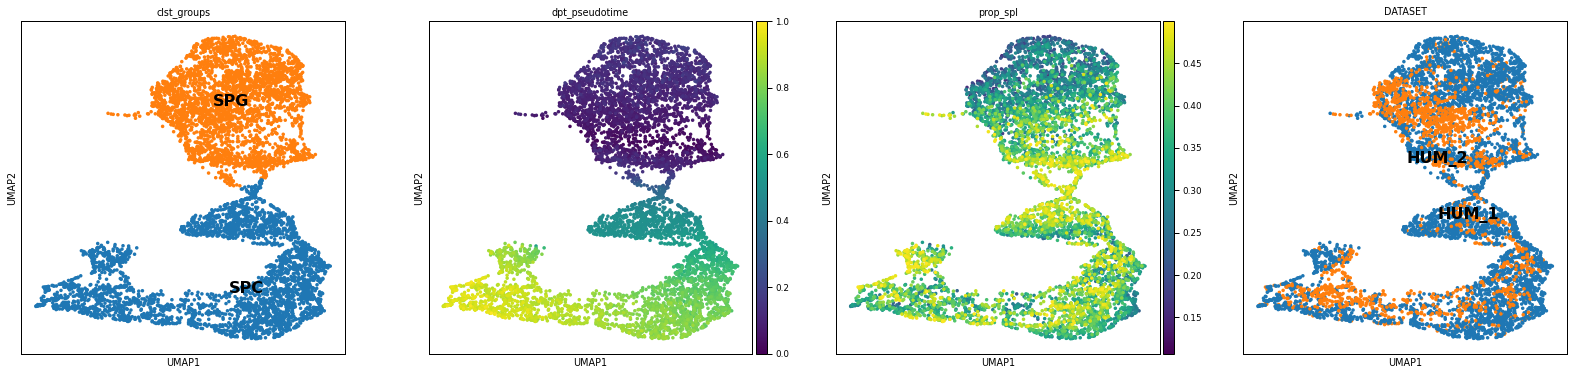

In [50]:
'''
d_dipl = adata[adata.obs["clst_groups"]!="SPT"].copy()
d_dipl_subs = d_dipl[:,aut_genes].copy()
sc.pp.highly_variable_genes(d_dipl_subs)
d_dipl_subs = d_dipl_subs[:,d_dipl_subs.var["highly_variable"]==True].copy()
d_dipl_subs.uns['iroot'] = np.flatnonzero(d_dipl_subs.obs['cluster'] == 'Spermatogonia')[0]
sc.tl.diffmap(d_dipl_subs)
sc.tl.dpt(d_dipl_subs,n_dcs=2)
d_dipl.obs["dpt_pseudotime"] = d_dipl_subs.obs["dpt_pseudotime"].copy()
sc.pl.umap(d_dipl, color=['clst_groups','dpt_pseudotime','prop_spl','DATASET'], legend_loc='on data', legend_fontsize=16, size=50)
'''

In [52]:
'''
d_dipl.obs["dpt_pseudotime_scaled"] = rescale(np.array(d_dipl.obs["dpt_pseudotime"]),0,0.5)
d_spt.obs["dpt_pseudotime_scaled"] = rescale(np.array(d_spt.obs["dpt_pseudotime"]),0.51,1)
d = ad.concat([d_dipl,d_spt])
adata = adata[d.obs_names].copy()
adata.obs["Pseudotime_scaled"] = d.obs["dpt_pseudotime_scaled"].copy()
sc.pl.violin(adata, groupby='clst_groups', keys=['Pseudotime_scaled'],order=["SPG","SPC","SPT"])
'''

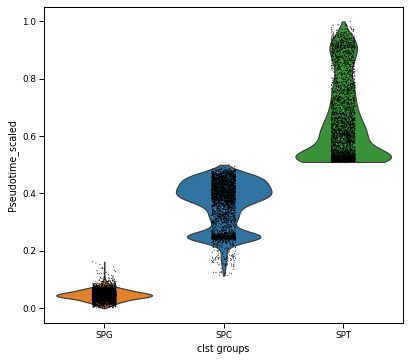

In [55]:
sc.pl.violin(adata, groupby='clst_groups', keys=['dpt_pseudotime'],order=["SPG","SPC","SPT"])

In [ ]:
adata = adata.concatenate(adata_somatic,index_unique=None)

In [56]:
adata.write(adata_out_clst)